In [ ]:
from landlab import RasterModelGrid
from landlab.io import esri_ascii
from landlab.utils.add_halo import add_halo
import numpy as np
import rasterio
import rasterio.features
import rasterio.warp
from landlab import RasterModelGrid



In [3]:
dataset = rasterio.open('output_be.tif')


In [4]:
print(dataset)

<open DatasetReader name='output_be.tif' mode='r'>


In [ ]:
#Dataset band is array representing part of a variable's distribution.
dataset.width
dataset.height

1929

In [ ]:
dataset.bounds #wow this is where the dataset is located irl
dataset.transform #this is how the pixel locations in (col, row) were mapped to (x, y)
#The product of this matrix and (0, 0), the upper loeft (col, row) is the IRL location of the upper left corner
#OH WAIT HOLY COW THIS IS JUST ROTATION MATRIX + OFFSET
#These coordinates are from 
dataset.crs #shows how far things are from the mapping thing


Affine(1.0, 0.0, 278056.0,
       0.0, -1.0, 4173332.0)

In [ ]:
#flow accumulator time
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FastscapeEroder
with rasterio.open('output_be.tif') as src:
    band1 = dataset.read(1).astype(float)
    raster_grid = RasterModelGrid(band1.shape, 1)
    #So you HAVE to name these that otherwise it gets mad later on. 
    #its just convention so ima stick with it.
    z = raster_grid.add_field("topographic__elevation", band1.flatten(), at="node") #can also get spacial coords of the r,c dataset by .index(x, y)
flow_accumulator = FlowAccumulator(raster_grid, "topographic__elevation", flow_director="D8") #flow accumulator basically sets all of the nodes in the grid to point somewhere it is going to drain down.
eroder = FastscapeEroder(raster_grid, K_sp=0.001, m_sp=0.55, n_sp=1.1)
for _ in range(20):
    flow_accumulator.run_one_step() #apparently landlab tried to make everything similar (ie all run one step)
    eroder.run_one_step(100) #the param is how many years it runs at once.
raster_grid.imshow('topographic__elevation', cmap="terrain")

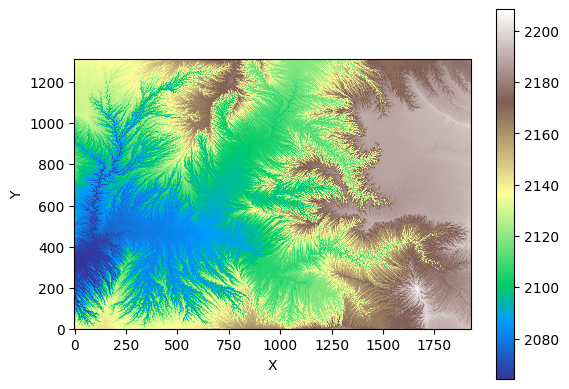

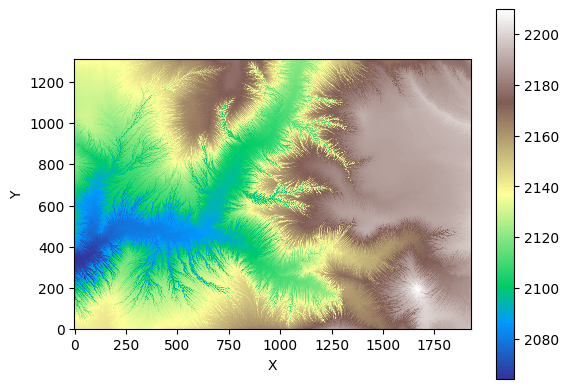

In [69]:
raster_grid.imshow('topographic__elevation', cmap="terrain")

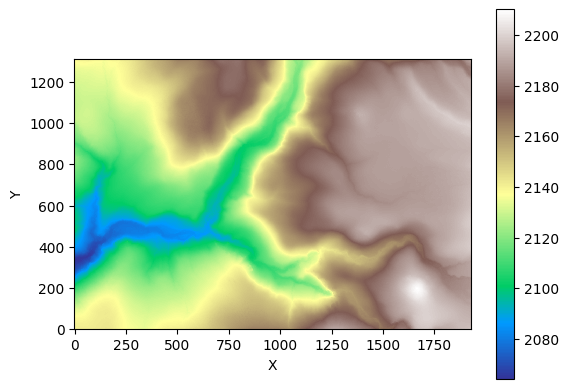

In [66]:
raster_grid_clean = RasterModelGrid(band1.shape, 1)
raster_grid_clean.add_field("topographic__elevation", band1.flatten(), at="node") #can also get spacial coords of the r,c dataset by .index(x, y)
raster_grid_clean.imshow("topographic__elevation", cmap="terrain")

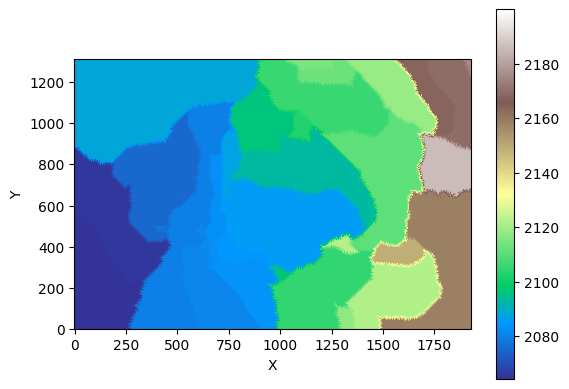

In [63]:
raster_grid.imshow("topographic__elevation", cmap="terrain")

In [161]:
from PIL import Image
import numpy as np

image_path = 'worlds_best_river.png' 
img = Image.open(image_path)
np_img = np.array(img)

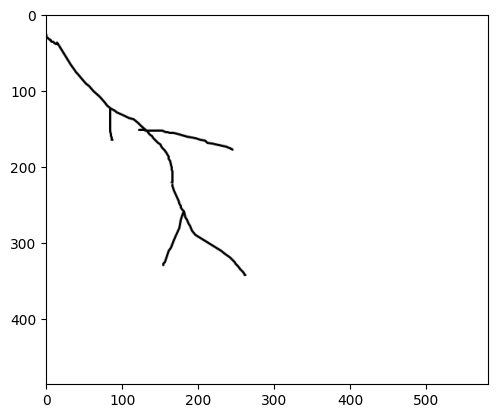

In [162]:
import matplotlib.pyplot as plt

plt.imshow(np_img)

In [ ]:
print(np.max(np_img)) #so from 0 to 255 scale.

255


In [179]:
# ima try it the ez way first. Just general flow from top left to bottom right.
#chat we actually need to think
#so i guess less do this without the random stuff first.

import random
def make_gradient(np_array, diff):
    #diff is the difference between the highest and lowest point.
    #So we have like uh 
    scale_factor = diff / (np_array.shape[1] + np_array.shape[0] - 1) 
    for i in range(np_array.shape[0]):
        for j in range(np_array.shape[1]):
            # np_array[i][j] -= (i + j + random.randint(0, int((np_array.shape[0] + np_array.shape[1]) / 1000))) * dz
            np_array[i][j] -= (i + j) *  scale_factor * random.randint(95, 105) / 100

def overlay_img(np_img, diff=10):
    terrain = np.zeros(np_img.shape[:2])
    make_gradient(terrain, diff)
    
    grayscale = np_img[:,:,0]
    whites = grayscale == 255
    blacks = grayscale == 0
    grayscale[whites] = 0 #reverse b and w
    grayscale[blacks] = 255 #check that it is between 1 and 255
    return terrain - diff * grayscale/255 #god i hate rgba

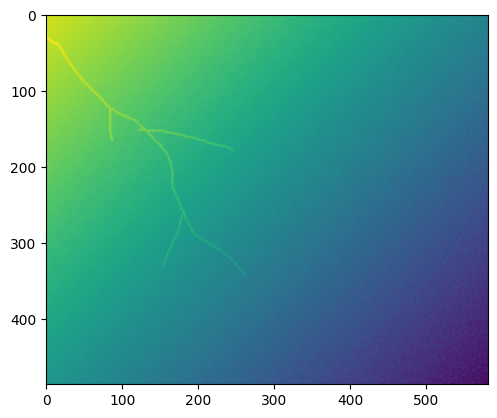

In [181]:
worlds_best_river = overlay_img(np_img)
plt.imshow(worlds_best_river)

In [ ]:
worlds_best_river_raster_grid = RasterModelGrid(worlds_best_river.shape, 1)
worlds_best_river_raster_grid.add_field("topographic__elevation", worlds_best_river.flatten(), at="node") #can also get spacial coords of the r,c dataset by .index(x, y)
flow_accumulator = FlowAccumulator(raster_grid, "topographic__elevation", flow_director="D8") #flow accumulator basically sets all of the nodes in the grid to point somewhere it is going to drain down.
eroder = FastscapeEroder(raster_grid, K_sp=0.001, m_sp=0.55, n_sp=1.1)

for _ in range(20):
    flow_accumulator.run_one_step() #apparently landlab tried to make everything similar (ie all run one step)
    eroder.run_one_step(100) #the param is how many years it runs at once.

raster_grid.imshow('topographic__elevation', cmap="terrain")